<a href="https://colab.research.google.com/github/Nautyy9/sentiment_analysis/blob/main/Sentiment_Analysis_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,GlobalMaxPooling1D,Embedding,TextVectorization,LayerNormalization,MultiHeadAttention
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
CONFIG={
    "BATCH_SIZE" : 64,
    "VOCAB_SIZE": 10000,
    "SEQ_LEN": 250,
    "EMBEDDING_DIMS": 300,
}

In [ ]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for review, label in train_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [ ]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [ ]:
vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens=CONFIG["VOCAB_SIZE"],
    output_mode = "int",
    output_sequence_length=CONFIG["SEQ_LEN"],
)

In [ ]:
# yoho =  val_ds.take(2).map(lambda x,y,:x)
# for i in yoho:
#   print(i)


training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data


In [ ]:
text = b'\x00\x00\xff\xfd\x00\x00\xff\xfd'
decoded_text = text.decode("UTF-8")
print(decoded_text)

UnicodeDecodeError: ignored

# Transformer

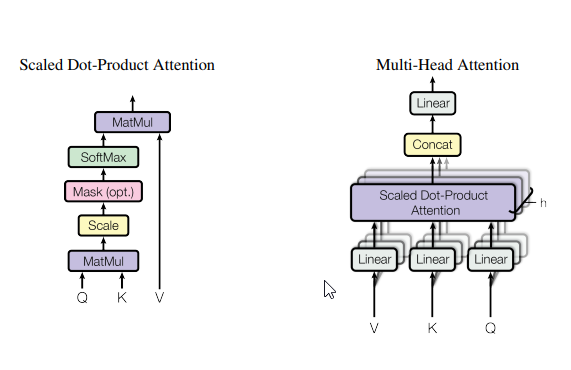

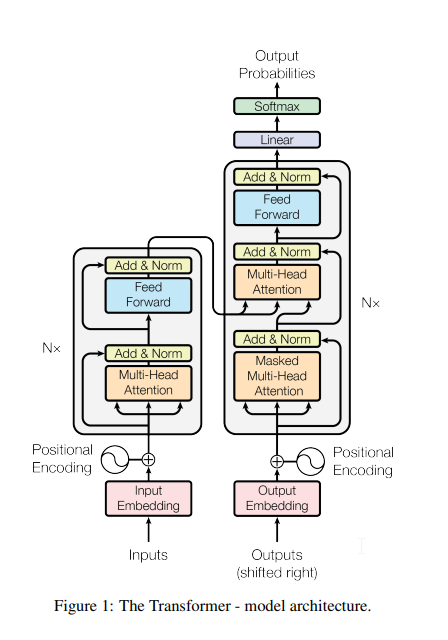

In [ ]:
##POSITIONAL_EMBEDDINGS

def pos_emb(model_size, seq_length):
  # model_size in here is the embedding_dimension and say we've  (300=emb_dim, 250=seq_len) then we know embedding_dim is equal to the total number of values inside the one seqence or word
  output=[]
  for pos in range(seq_length):
    PE = np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i] = np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i] = np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  # print(out)
  out=tf.expand_dims(out,axis=0)
  # print(out)
  return tf.cast(out, dtype=tf.float32)

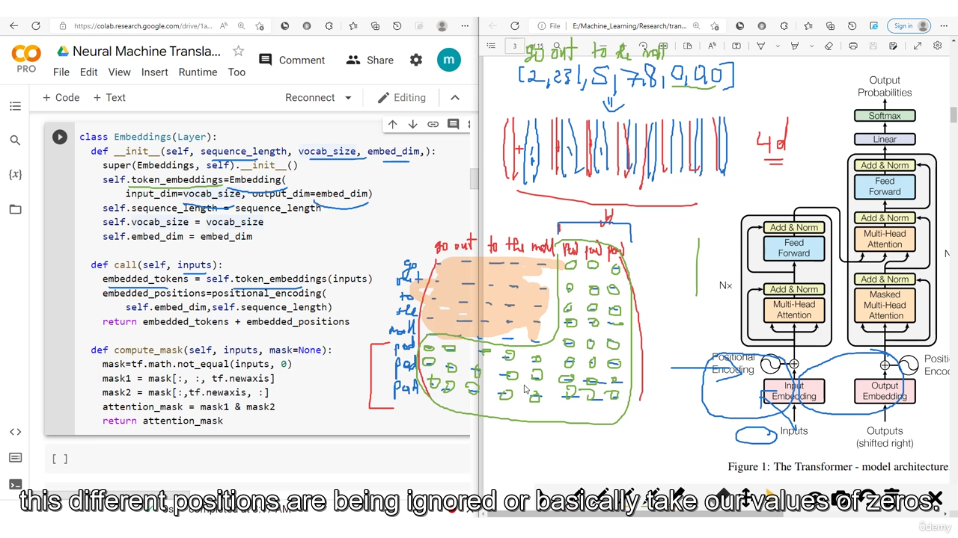

In [ ]:
# print(pos_emb(256).shape)

In [ ]:
## Embedding
class Embeddings(Layer):
  def __init__(self, embedding_dim, vocab_size, seq_length):
    super(Embeddings, self).__init__()
    self.emb_dim = embedding_dim
    self.vocab = vocab_size
    self.seq_len = seq_length
    self.embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim)

  def call(self, inputs):
    embedding_token = self.embedding_layer(inputs)
    embedding_positions = pos_emb(self.emb_dim, self.seq_len)
    return embedding_token + embedding_positions

    # up until here we have just returned the sum of the positional_embedding and input_embedding but now will make a singular matrix which is called attention mask

  def compute_mask(self, inputs, mask=None):
    # from  our matrix of positional_embedding and input_embdding we get a matrix where we have 0's and 1's and below we are selecting the only 1's value
    print(inputs.shape)
    mask = tf.math.not_equal(inputs, 0)
    # output shape is 1D array i.e, (1, seq_length)
    # the mask1 select both (1,seq_length=8) plus add a new axis using tf.newaxis
    mask1 = mask[:,:, tf.newaxis]
    # mask1 will output the shape of (1,seq_len=8,1)
    mask2=mask[:,tf.newaxis,:]
    # mask2 will output the shape of (1,8,1) hence it will be easier to perform & operation because (1,8)&(8,1)
    attention_mask = mask1&mask2
    print(attention_mask)
    return attention_mask
    # this attention mask will output the matrix whose values are... where both the mask_1 and mask_2 are 1 since 1&1 = 1

In [ ]:
# huhhh= tf.zeros(shape=(64,) , dtype=tf.int16)
# print(huhhh)

In [ ]:
emb = Embeddings(256, 20000,64)
# shape of returned emb is (1, seq_len=64, emb_dim=20)
emb_out =  emb(tf.constant([[12, 43, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]]))
print(emb_out.shape)

(1, 64)
(1, 64, 64)
(1, 64, 256)


In [ ]:
# yupp = tf.constant([12,234,534,52,6,423,0,0,0,0])
# mask = tf.expand_dims(tf.math.not_equal(yupp, 0),axis=0)
# print(mask.shape)

In [ ]:
# mask1=mask[:,:,tf.newaxis]
# print(mask1)
# mask2=mask[:,tf.newaxis,:]
# print(mask2)
# print(mask1&mask2)

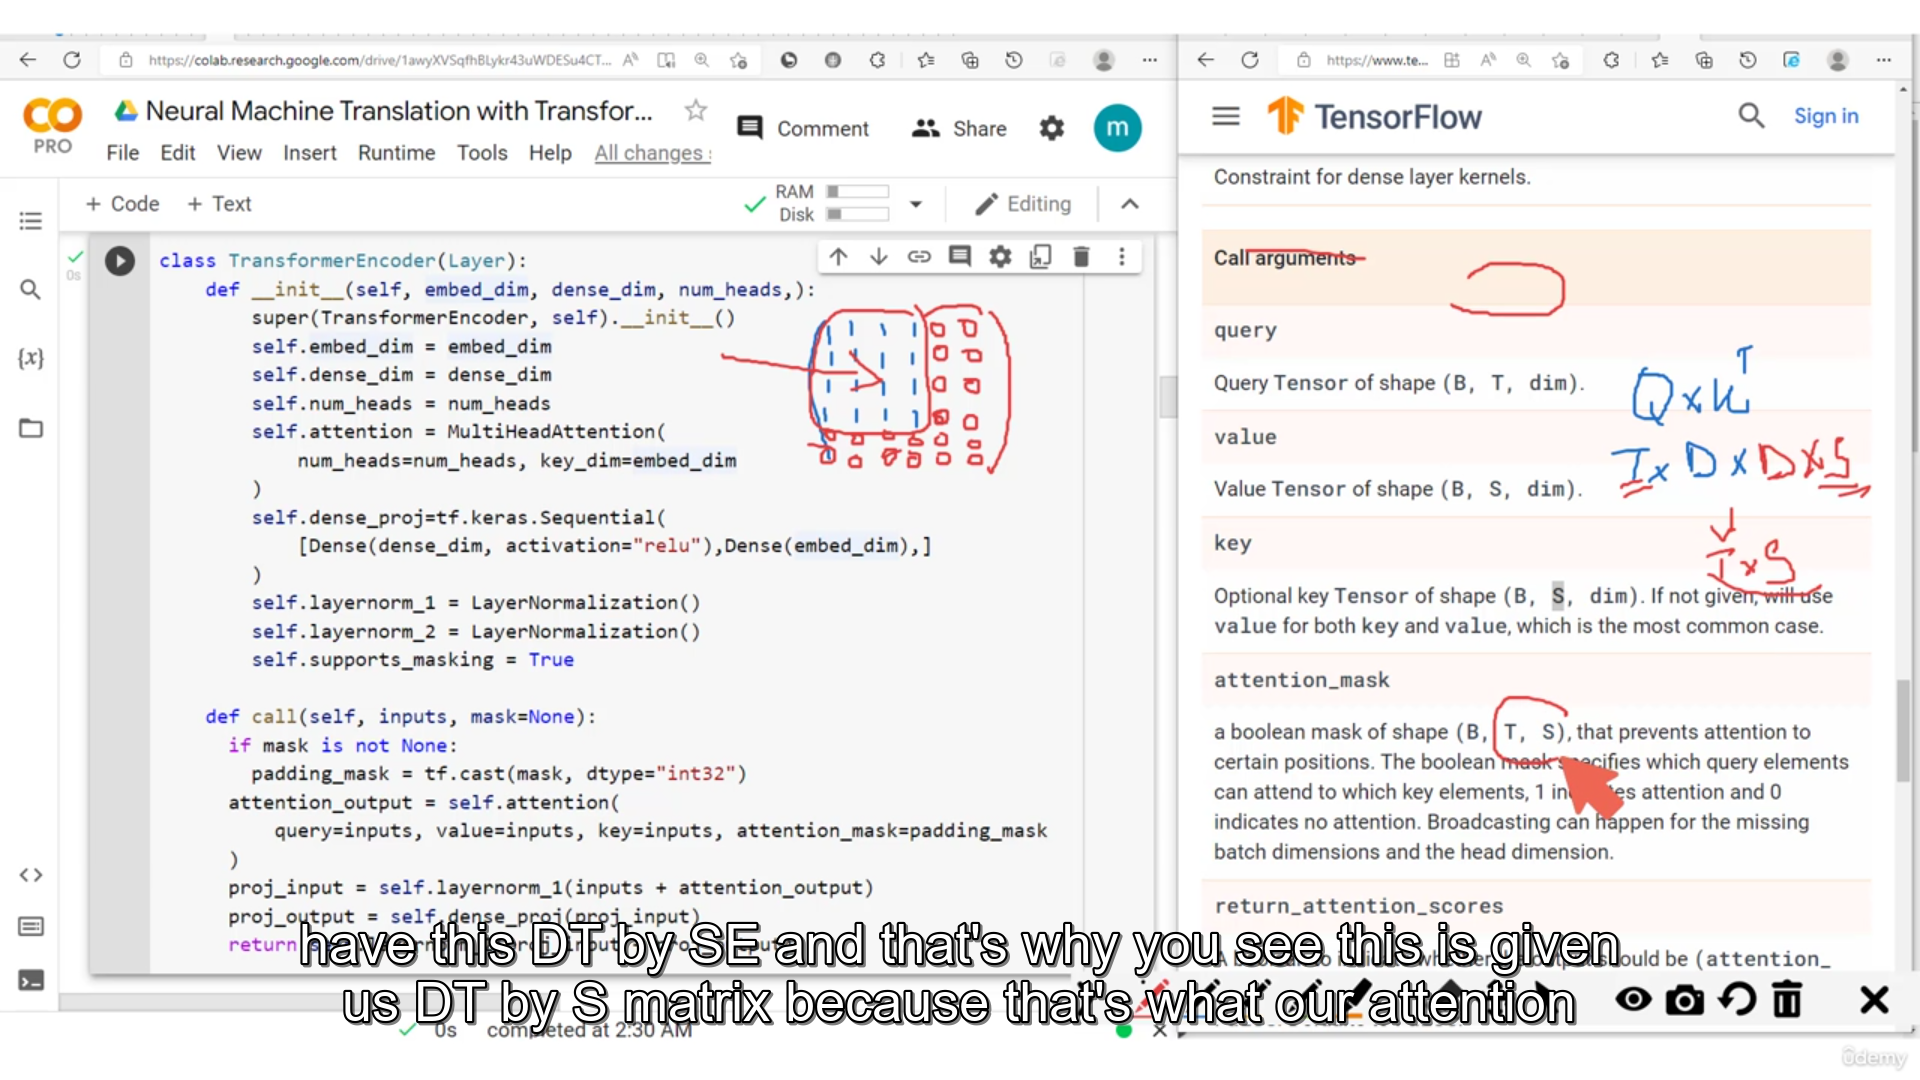

In [ ]:
### TransformerEncoder

# up until now we have just done embeddings now we have to pass these embeddings to encoder model

class TransformerEncoder(Layer):
  def __init__(self, embed_dim, dense_dim, num_heads):
    super(TransformerEncoder, self).__init__()
    # the feedforward config is having 2 dense layer where we first upscale the output and then downscale using another dense layer , this is done to match the the output dimension to the input_dim since we are adding them at end
    self.feed_forward = tf.keras.Sequential([Dense(dense_dim, activation="relu"), Dense(embed_dim)])
    self.layernorm1= LayerNormalization()
    self.layernorm2= LayerNormalization()
    # key_dim ---> Size of each attention head for query and key.
    self.attention = MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.supports_masking = True
    self.emb_dim=embed_dim
    self.dense_dim=dense_dim
    self.num_heads=num_heads

  def call(self, inputs, mask=None):
    # do mask if it already hasn't done
    print(inputs.shape)
    if mask is not None:
      padding_mask = tf.cast(mask, dtype="int32")
    # since we are taking in inputs which is combination of both positional and input encoding... now we need to convert them to matrix of 1's and 0's which is 1-0 word2word matrix
    attention = self.attention(query=inputs, value=inputs, attention_mask = padding_mask)
    norm1= self.layernorm1(inputs + attention)
    feed_forward = self.feed_forward(norm1)
    output = self.layernorm2(norm1 + feed_forward)
    return output

  # def get_config(self):
  #   config = super().get_config()
  #   config.update({
  #       "embed_dim": self.embed_dim,
  #       "num_heads": self.num_heads,
  #       "dense_dim": self.dense_dim,
  #   })
  #   return config
    # When calling super().get_config() in a subclass, it allows you to access and extend the configuration of the parent class while retaining its original behavior. You can modify or add to the configuration dictionary returned by super().get_config() to include additional subclass-specific configuration parameters or override existing ones.


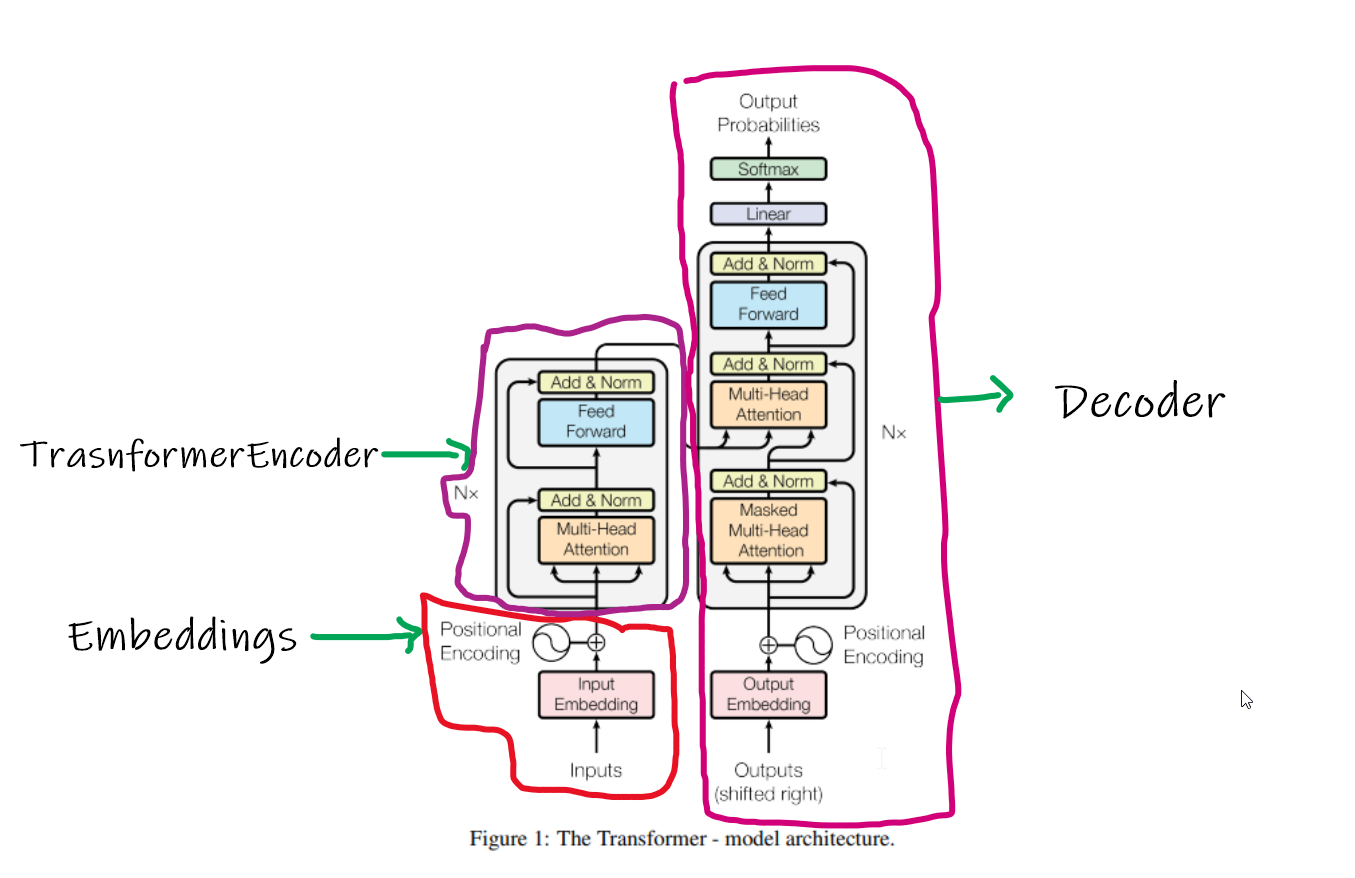

In [ ]:
encoder_output = TransformerEncoder(256, 2048, 8)(emb_out)
print(encoder_output.shape)

(1, 64, 256)


InvalidArgumentError: ignored